# Hiragana Handwritten Character Classifier

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import math

### Settings

In [2]:
# Japanese compatible font
plt.rcParams['font.sans-serif'] = "Microsoft YaHei" 

# Computation device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using device: CPU")

Using device: NVIDIA GeForce GTX 1060 6GB


In [3]:
DATASET_DIR = 'Kuzushiji-49'
DATASET_TRAIN_X_FILE = 'k49-train-imgs.npz'
DATASET_TRAIN_Y_FILE = 'k49-train-labels.npz'
DATASET_TEST_X_FILE = 'k49-test-imgs.npz'
DATASET_TEST_Y_FILE = 'k49-test-labels.npz'
DATASET_CLASSMAP = 'k49_classmap.csv'

### Prepare Dataset

In [4]:
train_images = torch.tensor(np.load(os.path.join(os.getcwd(), DATASET_DIR, DATASET_TRAIN_X_FILE))['arr_0'], dtype=torch.float32)
train_labels = torch.tensor(np.load(os.path.join(os.getcwd(), DATASET_DIR, DATASET_TRAIN_Y_FILE))['arr_0'], dtype=torch.int64)
test_images = torch.tensor(np.load(os.path.join(os.getcwd(), DATASET_DIR, DATASET_TEST_X_FILE))['arr_0'], dtype=torch.float32)
test_labels = torch.tensor(np.load(os.path.join(os.getcwd(), DATASET_DIR, DATASET_TEST_Y_FILE))['arr_0'], dtype=torch.int64)
print(f"Training Set: Input shape: {train_images.shape}. Output shape: {train_labels.shape}")
print(f"Testing Set: Input shape: {test_images.shape}. Output shape: {test_labels.shape}")

Training Set: Input shape: torch.Size([232365, 28, 28]). Output shape: torch.Size([232365])
Testing Set: Input shape: torch.Size([38547, 28, 28]). Output shape: torch.Size([38547])


In [5]:
class_map = pd.read_csv(os.path.join(os.getcwd(), DATASET_DIR, DATASET_CLASSMAP))
class_map[:5]

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お


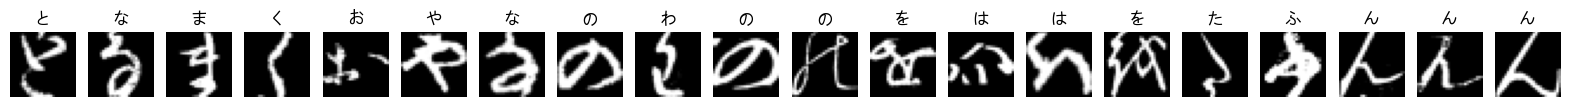

In [6]:
figure = plt.figure(figsize=(20, 5))
for i in range(1, 21):
    img = train_images[i]
    label = train_labels[i]
    figure.add_subplot(1, 20, i)
    plt.title(class_map['char'][int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# Put dataset into device
train_images = train_images.to(device)
train_labels = train_labels.to(device)
test_images = test_images.to(device)
test_labels = test_labels.to(device)

In [8]:
# Convert labels into one-hot encoder
train_labels = torch.nn.functional.one_hot(train_labels, num_classes=49).to(torch.float32)
test_labels = torch.nn.functional.one_hot(test_labels, num_classes=49).to(torch.float32)

In [9]:
# Add one dimension for channel
train_images = train_images.unsqueeze(1)
test_images = test_images.unsqueeze(1)

In [10]:
# Create validation set
validation_size = int(train_images.shape[0] * 0.1)
validate_images = train_images[-validation_size:]
train_images = train_images[:-validation_size]
validate_labels = train_labels[-validation_size:]
train_labels = train_labels[:-validation_size]

### Define Network

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=20,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels = 20,
                out_channels = 32, # out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 2
            ),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )

        self.linear1 = nn.Linear(32 * 7 * 7, 4 * 7 * 7)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(4 * 7 * 7, 2 * 7 * 7)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(2 * 7 * 7, 49)
        self.softmax_out = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.sigmoid2(x)
        x = self.linear3(x)
        output = self.softmax_out(x)
        return output

In [12]:
class VGG16(nn.Module):
    def __init__(self, K1=64, K2=128, K3=256, K4=512, K5=512):
        super(VGG16, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1, out_channels=K1, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K1, out_channels=K1, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 28->14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=K1, out_channels=K2, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K2, out_channels=K2, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 14 -> 7
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=K2, out_channels=K3, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K3, out_channels=K3, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K3, out_channels=K3, kernel_size=3, padding=1,
            ),                              
            nn.ReLU()
            # NO MAX-POOLING SINCE HERE
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(
                in_channels=K3, out_channels=K4, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K4, out_channels=K4, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K4, out_channels=K4, kernel_size=3, padding=1,
            ),                              
            nn.ReLU()
            # NO MAX-POOLING
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(
                in_channels=K4, out_channels=K5, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K5, out_channels=K5, kernel_size=3, padding=1,
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=K5, out_channels=K5, kernel_size=3, padding=1,
            ),                              
            nn.ReLU()
            # NO MAX-POOLING
        )

        self.linear1 = nn.Linear(K5 * 7 * 7, 1024)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(1024, 256)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(256, 49)
        self.softmax_out = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten the output of conv2 to (batch_size, kernel num * wid * height)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.sigmoid2(x)
        x = self.linear3(x)
        output = self.softmax_out(x)
        return output

### Train & Test

In [13]:
loss_func = nn.CrossEntropyLoss()

In [14]:
num_epochs = 1000
batch_size = 4200
PATIENCE = 5

LR = 0.0004

In [15]:
# model = CNN().to(device)
model = VGG16(K1=16, K2=16, K3=32, K4=48, K5=48).to(device)

In [25]:
optimizer = optim.Adam(model.parameters(), lr = LR) 
# Train the model
train_total_step = math.ceil(train_images.shape[0] / batch_size)
val_total_step = math.ceil(validate_images.shape[0] / batch_size)

prev_val_loss = math.inf
patience = PATIENCE
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(train_total_step):
        # clear gradients for this training step   
        optimizer.zero_grad()  
        
        # gives batch data, normalize x when iterate train_loader
        if ((i+1)*batch_size > train_images.shape[0]):
            b_x = train_images[i*batch_size:]  # batch x
            b_y = train_labels[i*batch_size:]   # batch y
        else:
            b_x = train_images[i*batch_size:(i+1)*batch_size]  # batch x
            b_y = train_labels[i*batch_size:(i+1)*batch_size]   # batch y

        output = model(b_x)               
        loss = loss_func(output, b_y)
        
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()                

        epoch_loss += loss.item()
        
    train_loss = (epoch_loss/train_total_step)

    # validation error
    model.eval()
    val_epoch_loss = 0
    for i in range(val_total_step):
        # gives batch data, normalize x when iterate train_loader
        if ((i+1)*batch_size > validate_images.shape[0]):
            b_x = validate_images[i*batch_size:]  # batch x
            b_y = validate_labels[i*batch_size:]   # batch y
        else:
            b_x = validate_images[i*batch_size:(i+1)*batch_size]  # batch x
            b_y = validate_labels[i*batch_size:(i+1)*batch_size]   # batch y

        output = model(b_x)               
        loss = loss_func(output, b_y)             
        val_epoch_loss += loss.item()
    val_loss = (val_epoch_loss/val_total_step)
    
    print (f'Epoch {epoch+1}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
    if ((val_loss > prev_val_loss) and (val_loss-prev_val_loss)>0.0005):
        patience -= 1
        print(f'Patience left: {patience}')
        if patience < 0:
            print(f'Early stopped')
            break
    else:
        patience += 0.5
        if patience > PATIENCE:
            patience = PATIENCE
    prev_val_loss = val_loss

Epoch 1, Training loss: 2.9368, Validation loss: 2.9739
Epoch 2, Training loss: 2.9361, Validation loss: 2.9725
Epoch 3, Training loss: 2.9355, Validation loss: 2.9714
Epoch 4, Training loss: 2.9351, Validation loss: 2.9708
Epoch 5, Training loss: 2.9350, Validation loss: 2.9710
Epoch 6, Training loss: 2.9350, Validation loss: 2.9710
Epoch 7, Training loss: 2.9348, Validation loss: 2.9712
Epoch 8, Training loss: 2.9348, Validation loss: 2.9713


KeyboardInterrupt: 

In [26]:
test_batch_size = batch_size

model.eval()
# Test the model
total_step = math.ceil(test_images.shape[0] / test_batch_size)

correct_num = 0
for i in range(total_step):
    # gives batch data, normalize x when iterate train_loader
    if ((i+1)*test_batch_size > test_images.shape[0]):
        b_x = test_images[i*test_batch_size:]  # batch x
        b_y = test_labels[i*test_batch_size:]   # batch y
    else:
        b_x = test_images[i*test_batch_size:(i+1)*test_batch_size]  # batch x
        b_y = test_labels[i*test_batch_size:(i+1)*test_batch_size]   # batch y

    output = model(b_x)
    predicted = torch.argmax(output, dim=1)
    ground_truth = torch.argmax(b_y, dim=1)
    matched_num = torch.count_nonzero((predicted == ground_truth)).item()
    correct_num += matched_num

print(f"Test accuracy: {correct_num/test_images.shape[0]}")

Test accuracy: 0.9258567463096998


Save the model:

In [27]:
torch.save(model.state_dict(), "VGG16.pt")

# TO load the model for evaluation:
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [28]:
model

VGG16(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): R

In [19]:
# new_model = VGG()
# new_model.load_state_dict(torch.load("VGG-64_128_256.pt"))
# new_model.eval()